In [1]:
import pickle
import collections
from urllib.request import urlopen
from data_processing import *

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 500)
#%matplotlib inline
acc_round_val = 2
f1_round_val = 4

# Set the task
task_name = 'swda'
# Get SwDA metadata and training set
base_url = 'https://raw.github.com/NathanDuran/Switchboard-Corpus/master/swda_data/'
metadata = pickle.load(urlopen(base_url + 'metadata/metadata.pkl'))
text_data = [line.decode('utf-8').rstrip('\r\n') for line in urlopen(base_url + 'train_set.txt')]

# Use Punctuation
Whether to remove punctuation from the input sentences or not.

Show punctuation flag value corresponding to max validation and test accuracy per model.

In [2]:
# Name of the experiment parameter for comparison
exp_param = 'use_punct'

# Load punctuation experiment data
punc_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
punc_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(punc_mean_data.loc[[punc_mean_data['val_acc'].idxmax()], ['model_name', exp_param, 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(punc_mean_data.loc[[punc_mean_data['test_acc'].idxmax()], ['model_name', exp_param, 'test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']])
punc_data_max = get_max(punc_mean_data, [exp_param])
punc_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

Best validation accuracy in mean data:
  model_name  use_punct    val_acc  val_acc_std
3   text cnn       True  75.611012     0.253492
Best test accuracy in mean data:
  model_name  use_punct   test_acc  test_acc_std  f1_weighted  f1_weighted_std
5       dcnn       True  72.798016       0.49409      0.70222         0.005578


,model_name,use_punct,val_acc,val_acc_std,use_punct,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,cnn,True,74.46,0.23,True,71.53,0.54,0.6857,0.0067
1,text cnn,True,75.61,0.25,True,72.79,0.33,0.7014,0.0038
2,dcnn,True,75.02,0.12,True,72.80,0.49,0.7022,0.0056
3,rcnn,True,74.06,0.45,True,72.00,0.58,0.6829,0.0073
4,lstm,True,75.25,0.18,True,72.34,0.54,0.6927,0.0055
5,gru,True,73.70,0.24,True,71.44,0.90,0.6788,0.0122


Plot accuracy of each model per punctuation flag value.

,model_name,use_punct,val_acc,val_acc_std,model_name,use_punct,val_acc,val_acc_std
0,cnn,True,74.46,0.23,cnn,False,73.49,0.24
1,text cnn,True,75.61,0.25,text cnn,False,74.64,0.16
2,dcnn,True,75.02,0.12,dcnn,False,73.96,0.18
3,rcnn,True,74.06,0.45,rcnn,False,73.37,0.26
4,lstm,True,75.25,0.18,lstm,False,74.34,0.21
5,gru,True,73.70,0.24,gru,False,72.91,0.33


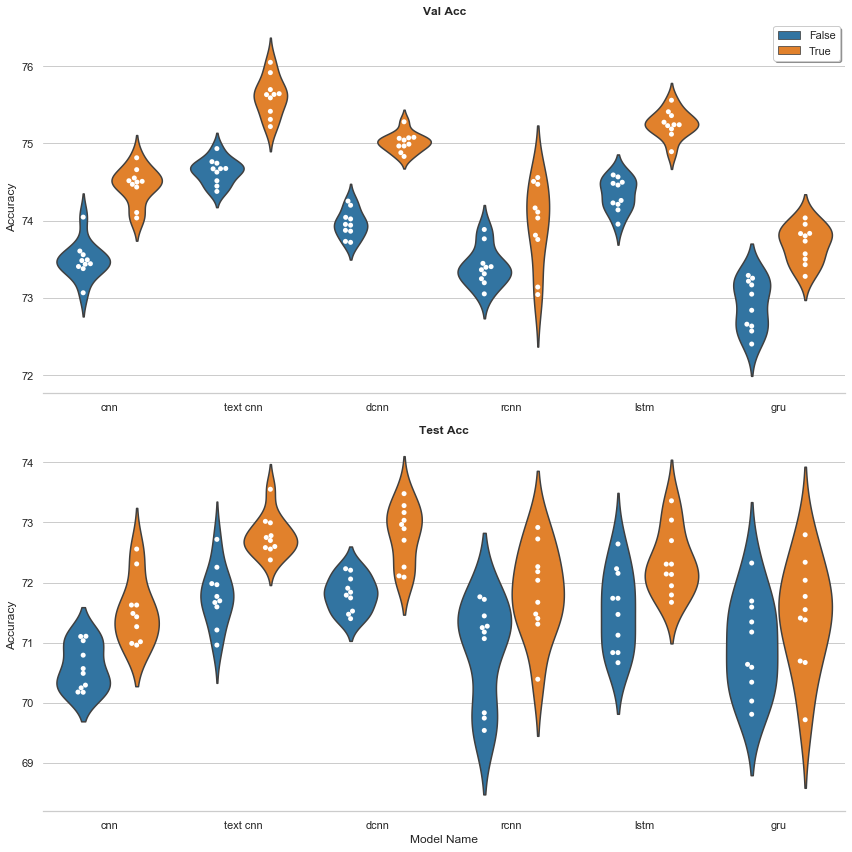

In [3]:
# Get test and validation accuracy for each model
punc_acc_data = punc_data.drop(punc_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
punc_acc_data = punc_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
punc_acc_data = punc_acc_data.melt(id_vars=['model_name', exp_param])

g, fig = plot_facetgrid(punc_acc_data, x="model_name", y="value", hue=exp_param, col='variable', kind='swarm_violin',
                            num_legend_col=1, y_label='Accuracy', x_label='Model Name',
                            share_y=False, num_col=1, dodge=True, colour='default')
g.savefig(os.path.join(task_name, exp_param, exp_param + '_accuracy.png'))

# Get the full validation accuracy/sd for punctuation false and true
punc_mean_data = punc_mean_data.drop(punc_mean_data.columns.difference(['model_name', exp_param, 'val_acc', 'val_acc_std']), axis=1)
punc_true = punc_mean_data[punc_mean_data['use_punct'] == True].reset_index(drop=True)
punc_false = punc_mean_data[punc_mean_data['use_punct'] == False].reset_index(drop=True)
punc_acc_data = pd.concat([punc_true, punc_false], axis=1, ignore_index=False).round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})
punc_acc_data

Test assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

Perform t-test comparing punctuation true and false for each model.

In [4]:
# Set the metric to test
metric = 'val_acc'

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(punc_data, exp_param, metric)

# Run Levene test for equal variance
levene_test(punc_data, exp_param, metric)

# Run t-test
punc_ttest_frame = t_test(punc_data, exp_param, metric)
punc_ttest_frame.round(5)

All models use_punct are normally distributed.
All models use_punct have equal variance.
All models have significant p-values when comparing use_punct groups.


c:\python\virtual environments\venv-tf-1.15\lib\site-packages\statsmodels\stats\power.py:415: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)


,model_name,t-stat,p-value,cohen-d,exp_n,exp_power,n,power
0,cnn,-9.09368,0.00000,-4.06682,2.38704,0.8,10.0,1.00000
1,text cnn,-10.17567,0.00000,-4.55070,2.22681,0.8,10.0,1.00000
2,dcnn,-15.49001,0.00000,-6.92734,[10.0],0.8,10.0,1.00000
3,rcnn,-2.96307,0.00833,-1.32512,9.99765,0.8,10.0,0.80010
4,lstm,-10.48906,0.00000,-4.69085,2.18934,0.8,10.0,1.00000
5,gru,-6.13262,0.00001,-2.74259,3.37547,0.8,10.0,0.99993


Per-label comparison between punctuation and no-punctuation for the TextCNN model

In [5]:
import re

# Create two empty dataframes
no_punc_frame = pd.DataFrame(columns=['model', 'label', 'precision' ,'recall' ,'f1-score' , 'support'])
punc_frame = pd.DataFrame(columns=['model', 'label', 'precision' ,'recall' ,'f1-score' , 'support'])

# Load the per-label scores for each model (punc and no-punc)
punc_and_lbl_path = os.path.join('raw_data', task_name, 'punct_and_labels')
for dir_name in os.listdir(punc_and_lbl_path):
    tmp_frame = pd.read_csv(os.path.join(punc_and_lbl_path, dir_name, dir_name + '_label_metrics.csv'))
    tmp_frame.insert(0, column='model', value=re.findall(r'\d+', dir_name)[0])
    tmp_frame.rename( columns={'Unnamed: 0':'label'}, inplace=True )

    # Concat frames
    if 'no_punc' in dir_name:
        no_punc_frame = pd.concat([no_punc_frame, tmp_frame])
    else:
        punc_frame = pd.concat([punc_frame, tmp_frame])

# Get averaged scores
no_punc_frame = no_punc_frame.groupby(['label', 'support'], as_index=False).mean()
no_punc_frame.sort_values('support', ascending=False, inplace=True)
no_punc_frame.reset_index(drop=True, inplace=True)
# print(no_punc_frame)
punc_frame = punc_frame.groupby(['label', 'support'], as_index=False).mean()
punc_frame.sort_values('support', ascending=False, inplace=True)
punc_frame.reset_index(drop=True, inplace=True)
# print(punc_frame)
punc_and_lbl_frame = pd.concat([no_punc_frame, punc_frame], keys=['no_punc', 'punc'], axis=1)
punc_and_lbl_frame.to_csv(os.path.join(task_name, 'punct_and_labels.csv'))
punc_and_lbl_frame.round(4)

no_punc                                                punc                                   
              label support precision  recall f1-score            label support precision  recall f1-score
0      weighted avg    4078    0.6988  0.7228   0.6979     weighted avg    4078    0.7042  0.7294   0.7012
1         micro avg    4078    0.7228  0.7228   0.7228        micro avg    4078    0.7294  0.7294   0.7294
2         macro avg    4078    0.4634  0.3639   0.3721        macro avg    4078    0.4657  0.3533   0.3726
3                sd    1317    0.7628  0.8270   0.7934               sd    1317    0.7271  0.8881   0.7993
4                 b     764    0.7337  0.9435   0.8253                b     764    0.7526  0.9390   0.8355
5                sv     718    0.6564  0.6496   0.6524               sv     718    0.7203  0.5524   0.6243
6                 %     349    0.7748  0.7822   0.7784                %     349    0.7938  0.8155   0.8041
7                aa     207    0.7635  0.4251   0.5439               aa     207    0.7229  0.4193   0.5283
8                qy      84    0.6842  0.7500   0.7143               qy      84    0.6923  0.7857   0.7349
9                fc      81    0.7633  0.5630   0.6452               fc      81    0.8158  0.5877   0.6825
10               ba      76    0.7345  0.8000   0.7658               ba      76    0.7553  0.8053   0.7788
11               ny      73    0.0000  0.0000   0.0000               ny      73    0.1714  0.0164   0.0283
12               qw      55    0.7018  0.6473   0.6724               qw      55    0.6991  0.7418   0.7192
13             qy^d      36    0.5072  0.1389   0.2162             qy^d      36    0.5319  0.1611   0.2394
14               bk      28    0.5654  0.2643   0.3060               bk      28    0.5272  0.2286   0.3004
15               ad      27    0.6012  0.2593   0.3610               ad      27    0.6694  0.2296   0.3367
16               nn      26    0.5306  1.0000   0.6933               nn      26    0.5432  0.9462   0.6857
17               bf      23    0.4000  0.0174   0.0333               bf      23    0.0500  0.0087   0.0148
18                h      23    0.8246  0.6522   0.7282                h      23    0.8367  0.5826   0.6822
19              b^m      21    0.4133  0.0571   0.0958              b^m      21    0.1862  0.1143   0.1298
20               bh      21    0.5124  0.4952   0.5021               bh      21    0.6961  0.6095   0.6464
21               ^2      19    0.0779  0.0526   0.0620               ^2      19    0.1812  0.0737   0.0996
22               ^q      17    0.4267  0.1176   0.1830               ^q      17    0.2800  0.0471   0.0785
23               qo      16    0.6330  0.7875   0.7005               qo      16    0.7157  0.7500   0.7321
24  fo_o_fw_"_by_bc      15    1.0000  0.0933   0.1691  fo_o_fw_"_by_bc      15    0.5714  0.1067   0.1389
25               qh      12    0.3948  0.2833   0.3275               qh      12    0.4524  0.3000   0.3506
26               na      10    0.0000  0.0000   0.0000               na      10    0.0000  0.0000   0.0000
27               br       9    0.7000  0.2667   0.3846               br       9    0.8629  0.4444   0.5799
28               ^h       7    0.4833  0.1429   0.2108               ^h       7    0.5333  0.1429   0.2189
29               ft       7    0.0000  0.0000   0.0000               ft       7    0.0000  0.0000   0.0000
30           aap_am       7    0.0000  0.0000   0.0000           aap_am       7    0.0000  0.0000   0.0000
31               no       6    0.0000  0.0000   0.0000               no       6    0.0000  0.0000   0.0000
32               ng       6    0.4400  0.3000   0.3515               ng       6    0.7167  0.3333   0.4478
33               fp       5    1.0000  0.6000   0.7421               fp       5    1.0000  0.2800   0.4286
34           arp_nd       3    0.0000  0.0000   0.0000           arp_nd       3    0.0000  0.0000   0.0000
35               ar       3    0.0000  0.0000   0.000

# Letter Case
Whether to lowercase all words from the input sentences or not.

Show lowercase flag value corresponding to max validation and test accuracy per model.

In [6]:
# Name of the experiment parameter for comparison
exp_param = 'to_lower'

# Load punctuation experiment data
case_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
case_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(case_mean_data.loc[[case_mean_data['val_acc'].idxmax()], ['model_name', exp_param, 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(case_mean_data.loc[[case_mean_data['test_acc'].idxmax()], ['model_name', exp_param, 'test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']])
case_data_max = get_max(case_mean_data, [exp_param])
case_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

Best validation accuracy in mean data:
  model_name  to_lower    val_acc  val_acc_std
3   text cnn      True  75.333085     0.228255
Best test accuracy in mean data:
  model_name  to_lower  test_acc  test_acc_std  f1_weighted  f1_weighted_std
9       lstm      True   72.7417      0.573446      0.69615         0.006807


,model_name,to_lower,val_acc,val_acc_std,to_lower,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,cnn,True,74.73,0.19,False,71.80,0.51,0.6890,0.0067
1,text cnn,True,75.33,0.23,True,72.68,0.37,0.6996,0.0050
2,dcnn,True,74.54,0.19,True,72.33,0.71,0.6945,0.0093
3,rcnn,True,74.46,0.29,True,71.92,0.46,0.6846,0.0061
4,lstm,True,75.24,0.20,True,72.74,0.57,0.6962,0.0068
5,gru,False,74.28,0.40,True,71.83,0.36,0.6841,0.0057


Plot accuracy of each model per lowercase flag value.

,model_name,to_lower,val_acc,val_acc_std,model_name,to_lower,val_acc,val_acc_std
0,cnn,True,74.73,0.19,cnn,False,74.45,0.23
1,text cnn,True,75.33,0.23,text cnn,False,74.77,0.20
2,dcnn,True,74.54,0.19,dcnn,False,74.13,0.20
3,rcnn,True,74.46,0.29,rcnn,False,74.13,0.32
4,lstm,True,75.24,0.20,lstm,False,74.84,0.15
5,gru,True,74.26,0.17,gru,False,74.28,0.40


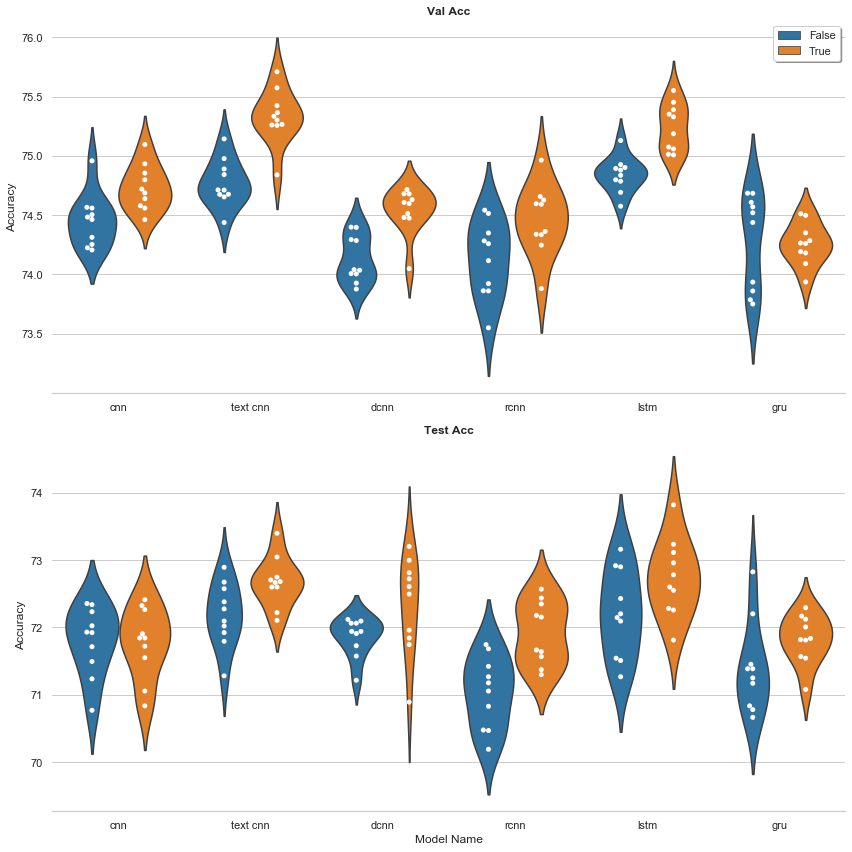

In [7]:
# Get test and validation accuracy for each model
case_acc_data = case_data.drop(case_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
case_acc_data = case_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
case_acc_data = case_acc_data.melt(id_vars=['model_name', exp_param])

g, fig = plot_facetgrid(case_acc_data, x="model_name", y="value", hue=exp_param, col='variable', kind='swarm_violin',
                            num_legend_col=1, y_label='Accuracy', x_label='Model Name',
                            share_y=False, num_col=1, dodge=True, colour='default')
g.savefig(os.path.join(task_name, exp_param, exp_param + '_accuracy.png'))

# Get the full validation accuracy/sd for lowercase false and true
case_mean_data = case_mean_data.drop(case_mean_data.columns.difference(['model_name', exp_param, 'val_acc', 'val_acc_std']), axis=1)
lower_case_true = case_mean_data[case_mean_data['to_lower'] == True].reset_index(drop=True)
lower_case_false = case_mean_data[case_mean_data['to_lower'] == False].reset_index(drop=True)
case_acc_data = pd.concat([lower_case_true, lower_case_false], axis=1, ignore_index=False).round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})
case_acc_data

Test assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

Perform t-test comparing lowercase true and false for each model.

In [8]:
# Set the metric to test
metric = 'val_acc'

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(case_data, exp_param, metric)

# Run Levene test for equal variance
levene_test(case_data, exp_param, metric)

# Run t-test
case_ttest_frame = t_test(case_data, exp_param, metric)
case_ttest_frame.round(5)

The following to_lower are not normally distributed.
   model_name to_lower    t-stat   p-value
5        dcnn     True  0.768321  0.005966
10        gru    False  0.810507  0.019448
The following models to_lower do not have equal variance.
  model_name  to_lower   t-stat   p-value
5        gru       NaN  4.52943  0.047387
The following models do not have significant p-values when comparing to_lower groups.
  model_name    t-stat   p-value   cohen-d        exp_n  exp_power     n     power
5        gru  0.194925  0.847635  0.087173  2066.675633        0.8  10.0  0.053919


,model_name,t-stat,p-value,cohen-d,exp_n,exp_power,n,power
0,cnn,-2.99621,0.00775,-1.33995,9.80305,0.8,10.0,0.80873
1,text cnn,-5.88205,0.00001,-2.63053,3.53969,0.8,10.0,0.99983
2,dcnn,-4.78053,0.00015,-2.13792,4.62364,0.8,10.0,0.99466
3,rcnn,-2.42550,0.02603,-1.08472,14.36821,0.8,10.0,0.63114
4,lstm,-5.11618,0.00007,-2.28803,4.21341,0.8,10.0,0.99794
5,gru,0.19493,0.84763,0.08717,2066.67563,0.8,10.0,0.05392


# Vocabulary Size
The number of words to keep in the vocabulary during pre-processing.
Less frequent words were considered OOV and replaced with the <unk> token. Increments of 500 in the range [500, 8000].

Get the vocabulary size corresponding to max validation and test accuracy per model.

In [9]:
# Name of the experiment parameter for comparison
exp_param = 'vocab_size'

# Load vocabulary experiment data
vocab_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
vocab_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(vocab_mean_data.loc[[vocab_mean_data['val_acc'].idxmax()], ['model_name', exp_param, 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(vocab_mean_data.loc[[vocab_mean_data['test_acc'].idxmax()], ['model_name', exp_param, 'test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']])
vocab_data_max = get_max(vocab_mean_data, [exp_param])
vocab_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

Best validation accuracy in mean data:
   model_name  vocab_size    val_acc  val_acc_std
22   text cnn        5500  75.611698     0.252162
Best test accuracy in mean data:
   model_name  vocab_size   test_acc  test_acc_std  f1_weighted  f1_weighted_std
73       lstm        2500  72.904949       0.46696     0.698919         0.005982


,model_name,vocab_size,val_acc,val_acc_std,vocab_size,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,cnn,2500,74.50,0.24,7500,71.85,0.63,0.6878,0.0073
1,text cnn,5500,75.61,0.25,2500,72.85,0.36,0.7024,0.0040
2,dcnn,7500,75.15,0.13,8000,72.70,0.61,0.6978,0.0086
3,rcnn,7500,74.36,0.49,7000,71.77,0.80,0.6837,0.0108
4,lstm,7000,75.25,0.18,2500,72.90,0.47,0.6989,0.0060
5,gru,8000,73.89,0.36,6500,71.94,0.38,0.6849,0.0065


Plot accuracy of each model per vocabulary size.

Vertical lines are the mean frequency of word occurrence within a given range
i.e. the 500-1000 most frequent words appear, on average, ~159 times.

    vocab_size    mean_freq    cum_sum
0        500.0  3373.836327  1690292.0
1       1000.0   159.123752  1769750.0
2       1500.0    72.768463  1806110.0
3       2000.0    43.662675  1827930.0
4       2500.0    29.966068  1842908.0
5       3000.0    22.500998  1854155.0
6       3500.0    17.395210  1862850.0
7       4000.0    13.984032  1869841.0
8       4500.0    11.471058  1875575.0
9       5000.0     9.558882  1880354.0
10      5500.0     8.233533  1884470.0
11      6000.0     7.107784  1888023.0
12      6500.0     6.123752  1891084.0
13      7000.0     5.465070  1893816.0
14      7500.0     5.000000  1896316.0
15      8000.0     4.164000  1898393.0
Total word count: 1922227
Percentage of words for vocabulary size 2500: 95.87


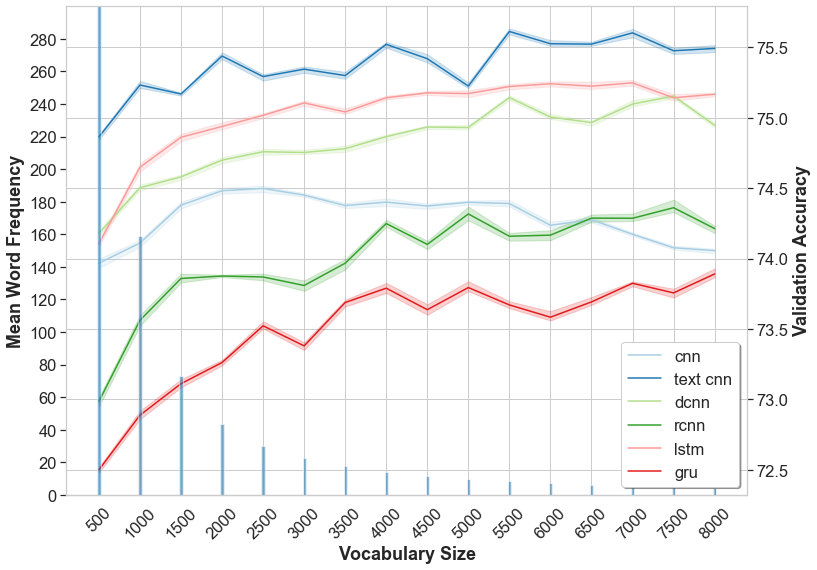

In [10]:
# Get word frequencies from metadata and bin into same values as experiment
word_freq = metadata['word_freq'].iloc[:8000]
words_frame = pd.DataFrame(columns=['vocab_size', 'mean_freq', 'cum_sum'])
ind_start, ind_end = 0, 500
for i in range(16):
    words_frame = words_frame.append({'vocab_size': ind_end,
                        'mean_freq': float(word_freq.loc[ind_start:ind_end].mean()), # Binning
                        'cum_sum': word_freq.loc[0:ind_end].sum()['Count']}, # Cumulative summing
                       ignore_index=True)
    ind_start += 500
    ind_end += 500
print(words_frame)

# Calculate percentage of words up to specified vocabulary size
vocab_size = 2500
total_words = metadata['word_freq']['Count'].sum()
word_cum_sum = float(words_frame.loc[(words_frame['vocab_size'] == vocab_size)]['cum_sum'])
perc_of_total = (100 / total_words) * word_cum_sum
print("Total word count: " + str(total_words))
print("Percentage of words for vocabulary size " + str(vocab_size) + ": " + str(round(perc_of_total, 2)))

# Get experiment validation accuracy data for each model
vocab_acc_data = vocab_data.drop(vocab_data.columns.difference(['model_name', exp_param, 'val_acc']), axis=1)
vocab_acc_data = vocab_acc_data.rename(columns={'val_acc': 'Val Acc'})
vocab_acc_data = vocab_acc_data.melt(id_vars=['model_name', exp_param])

# Plot line/bar chart
fig = plot_line_bar_chart(vocab_acc_data, words_frame, x=exp_param, y='value', hue='model_name',
                          title='', y_label='Validation Accuracy', x_label='Vocabulary Size', colour='Paired',
                          bar_x=exp_param, bar_y='mean_freq', bar_axis_step=20, bar_axis_range=[0, 300], bar_width=40,
                          bar_y_label='Mean Word Frequency', bar_alpha=0.5, bar_color='tab:blue',
                          legend_loc='lower right', num_legend_col=1, xtick_rotation=45)
fig.savefig(os.path.join(task_name, exp_param, exp_param + '_accuracy.png'))

Test ANOVA assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

Perform ANOVA for each model, comparing different vocabulary size groups.

In [11]:
# Set the metric to test
metric = 'val_acc'

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(vocab_data, exp_param, metric)

# Run Levene test for equal variance
levene_test(vocab_data, exp_param, metric)

# Run ANOVA
one_way_anova_test(vocab_data, exp_param, metric)

The following vocab_size are not normally distributed.
   model_name vocab_size    t-stat   p-value
11        cnn       6000  0.795897  0.012926
23   text cnn       4000  0.825525  0.029552
50       rcnn       1500  0.838141  0.041918
62       rcnn       7500  0.753438  0.003930
76       lstm       6500  0.815660  0.022456
All models vocab_size have equal variance.
All models have significant p-values when comparing vocab_size groups.


c:\python\virtual environments\venv-tf-1.15\lib\site-packages\statsmodels\stats\power.py:415: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
c:\python\virtual environments\venv-tf-1.15\lib\site-packages\statsmodels\stats\power.py:415: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
c:\python\virtual environments\venv-tf-1.15\lib\site-packages\statsmodels\stats\power.py:415: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq,cohen_f,n,exp_n,power,exp_power
cnn,4.15519,15,0.277013,5.32635,2.02539e-08,0.356842,0.288558,0.499345,160,51.4887,0.999998,0.8
text cnn,5.63625,15,0.37575,6.17824,6.64504e-10,0.391567,0.326808,0.57921,160,46.4613,1,0.8
dcnn,9.82208,15,0.654805,15.7466,1.83888e-23,0.621251,0.580272,1.4,160,[160.0],1,0.8
rcnn,18.7598,15,1.25066,10.3505,1.79582e-16,0.518809,0.467124,0.970361,160,34.0469,1,0.8
lstm,12.9309,15,0.862063,17.2187,3.89119e-25,0.642041,0.603254,1.4,160,[160.0],1,0.8
gru,22.1739,15,1.47826,14.9538,1.59746e-22,0.609022,0.566756,1.4,160,[160.0],1,0.8


Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

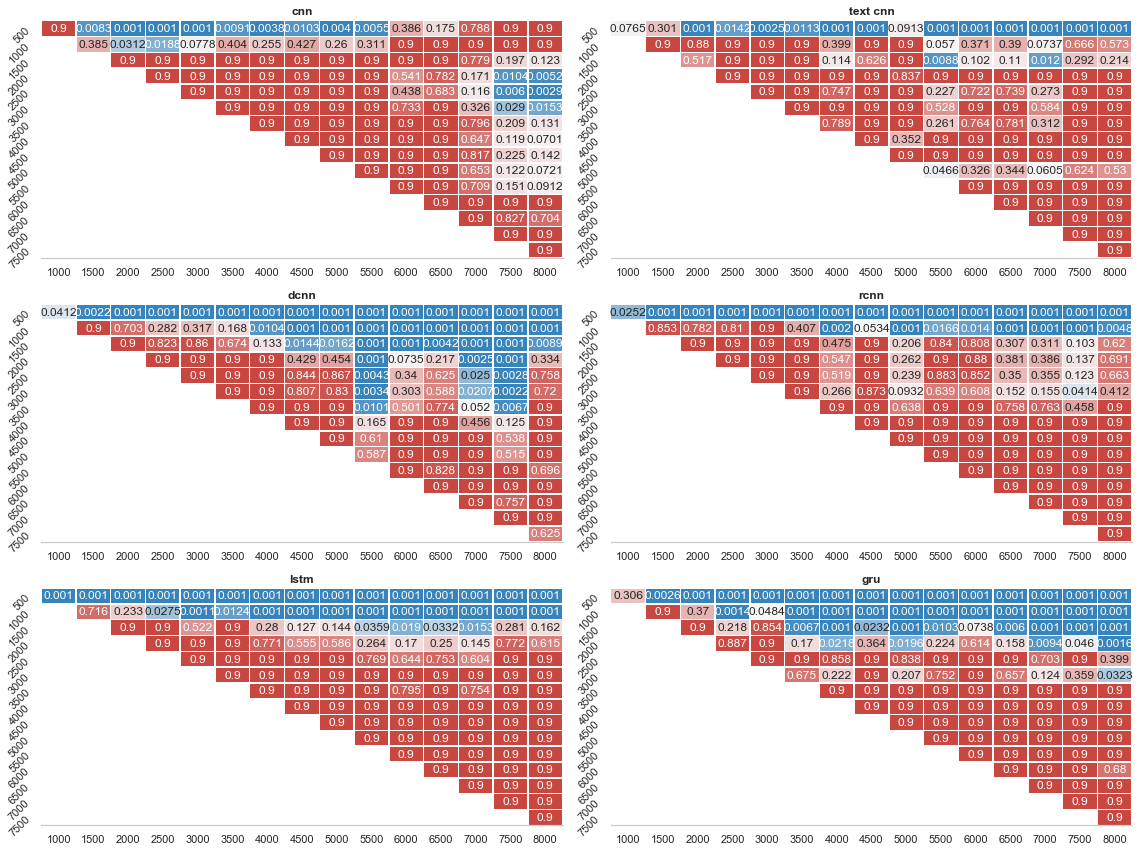

In [12]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(vocab_data, exp_param, metric, show_result=False)

# Remove vocab_size > 5000 to make plots nicer
# tukey_frame.drop(tukey_frame[(tukey_frame.group1 > 5000) | (tukey_frame.group2 > 5000)].index, inplace=True)
# Generate heatmaps
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.05, 1.0],
                        y_tick_rotation=45, height=4)
# g.savefig(os.path.join(task_name, exp_param, exp_param + '_anova.png'))

# Sequence Length
The number of tokens in the input sequence. Sentences are padded, with a <pad> token, or truncated to this length.
Increments of 5 in the range [5, 50].

Get the sequence length corresponding to max validation and test accuracy per model.

In [13]:
# Name of the experiment parameter for comparison
exp_param = 'max_seq_length'

# Load sequence length experiment data
seq_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
seq_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(seq_mean_data.loc[[seq_mean_data['val_acc'].idxmax()], ['model_name', exp_param, 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(seq_mean_data.loc[[seq_mean_data['test_acc'].idxmax()], ['model_name', exp_param, 'test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']])
seq_data_max = get_max(seq_mean_data, [exp_param])
seq_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

Best validation accuracy in mean data:
   model_name  max_seq_length    val_acc  val_acc_std
14   text cnn              25  75.633028      0.24392
Best test accuracy in mean data:
   model_name  max_seq_length   test_acc  test_acc_std  f1_weighted  f1_weighted_std
40       lstm              50  72.914715      0.277824     0.698838         0.003376


,model_name,max_seq_length,val_acc,val_acc_std,max_seq_length,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,cnn,45,74.43,0.17,35,71.78,0.43,0.6886,0.0048
1,text cnn,25,75.63,0.24,20,72.82,0.28,0.7014,0.0034
2,dcnn,30,75.10,0.23,35,72.68,0.25,0.6997,0.0033
3,rcnn,40,74.50,0.28,50,72.20,0.43,0.6874,0.0056
4,lstm,25,75.35,0.16,50,72.91,0.28,0.6988,0.0034
5,gru,25,73.94,0.27,40,72.11,0.38,0.6882,0.0045


Plot accuracy of each model per sequence length.

Vertical lines are the cumulative frequency of utterances up to a given sequence length
i.e. there are 145129 sentences in the test set of length <= 10.

   max_seq_length     mean_freq   cum_sum
0             5.0  20326.200000  101631.0
1            10.0   8995.666667  145129.0
2            15.0   4959.666667  168097.0
3            20.0   2518.500000  179728.0
4            25.0   1289.333333  185700.0
5            30.0    658.833333  188789.0
6            35.0    353.833333  190424.0
7            40.0    191.833333  191330.0
8            45.0    100.166667  191794.0
9            50.0     52.500000  192048.0
Total sentence count: 192390
Percentage of sentences for sequence length 25: 96.52


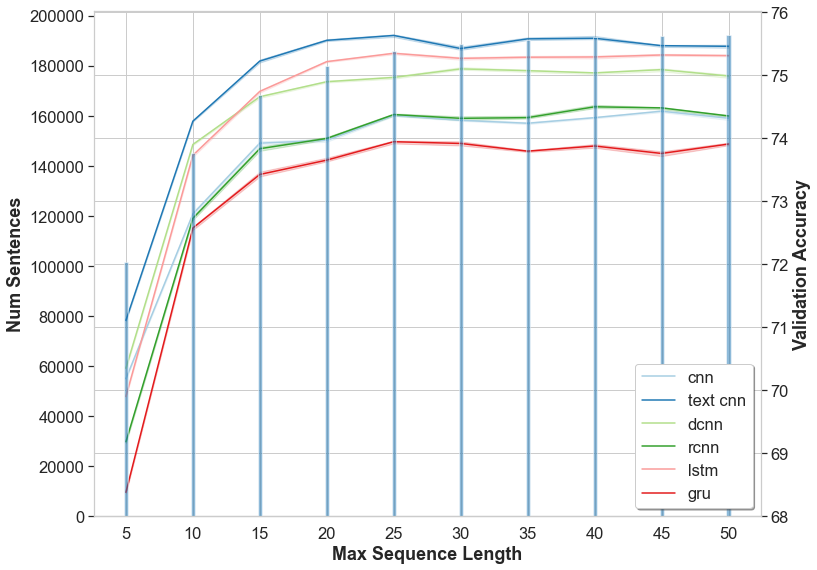

In [14]:
# Get text data from training set and count sequence lengths
sentences = [line.split('|')[1] for line in text_data]
sent_lengths = [len(sent.split(' ')) for sent in sentences]
sent_lengths = collections.Counter(sent_lengths)
sent_lengths = pd.DataFrame.from_dict(dict(sorted(sent_lengths.items())), orient='index')

# Get word sentence lengths and bin/sum into same values as experiment
sents_frame = pd.DataFrame(columns=['max_seq_length', 'mean_freq', 'cum_sum'])
ind_start, ind_end = 0, 5
for i in range(10):
    sents_frame = sents_frame.append({'max_seq_length': ind_end,
                        'mean_freq': float(sent_lengths.loc[ind_start:ind_end].mean()), # Binning
                        'cum_sum': float(sent_lengths.loc[0:ind_end].sum())}, # Cumulative summing
                       ignore_index=True)
    ind_start += 5
    ind_end += 5
print(sents_frame)

# Calculate percentage of sentences up to specified max length
seq_len = 25
total_sent = int(sent_lengths.sum())
sent_cum_sum = float(sents_frame.loc[(sents_frame['max_seq_length'] == seq_len)]['cum_sum'])
perc_of_total = (100 / total_sent) * sent_cum_sum
print("Total sentence count: " + str(total_sent))
print("Percentage of sentences for sequence length " + str(seq_len) + ": " + str(round(perc_of_total, 2)))

# Get experiment validation accuracy data for each model
seq_acc_data = seq_data.drop(seq_data.columns.difference(['model_name', exp_param, 'val_acc']), axis=1)
seq_acc_data = seq_acc_data.rename(columns={'val_acc': 'Val Acc'})
seq_acc_data = seq_acc_data.melt(id_vars=['model_name', exp_param])

# Plot line/bar chart
fig = plot_line_bar_chart(seq_acc_data, sents_frame, x=exp_param, y='value', hue='model_name',
                          title='', y_label='Validation Accuracy', x_label='Max Sequence Length', colour='Paired',
                          bar_x=exp_param, bar_y='cum_sum', bar_axis_step=20000, bar_axis_range=None, bar_width=0.3,
                          bar_y_label='Num Sentences', bar_alpha=0.5, bar_color='tab:blue',
                          legend_loc='lower right', num_legend_col=1)
fig.savefig(os.path.join(task_name, exp_param, exp_param + '_accuracy.png'))

Test ANOVA assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

Perform ANOVA for each model, comparing different sequence length groups.

In [15]:
# Set the metric to test
metric = 'val_acc'

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(seq_data, exp_param, metric)

# Run Levene test for equal variance
levene_test(seq_data, exp_param, metric)

# Run ANOVA
one_way_anova_test(seq_data, exp_param, metric)

The following max_seq_length are not normally distributed.
   model_name max_seq_length    t-stat   p-value
4         cnn             25  0.779160  0.008086
17   text cnn             40  0.817419  0.023584
51        gru             10  0.819752  0.025168
All models max_seq_length have equal variance.
All models have significant p-values when comparing max_seq_length groups.


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq,cohen_f,n,exp_n,power,exp_power
cnn,156.994288,9.0,17.443810,364.465080,8.926812e-67,0.973295,0.970337,1.4,100.0,21.273918,1.0,0.8
text cnn,177.002078,9.0,19.666898,372.079519,3.614924e-67,0.973827,0.970928,1.4,100.0,21.273918,1.0,0.8
dcnn,194.943510,9.0,21.660390,480.181912,4.985668e-72,0.979599,0.977338,1.4,100.0,21.273918,1.0,0.8
rcnn,243.302778,9.0,27.033642,374.900643,2.597900e-67,0.974019,0.971141,1.4,100.0,21.273918,1.0,0.8
lstm,262.223599,9.0,29.135955,760.126463,7.580867e-81,0.987015,0.985574,1.4,100.0,21.273918,1.0,0.8
gru,265.610882,9.0,29.512320,323.453113,1.631616e-64,0.970011,0.966690,1.4,100.0,21.273918,1.0,0.8


Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

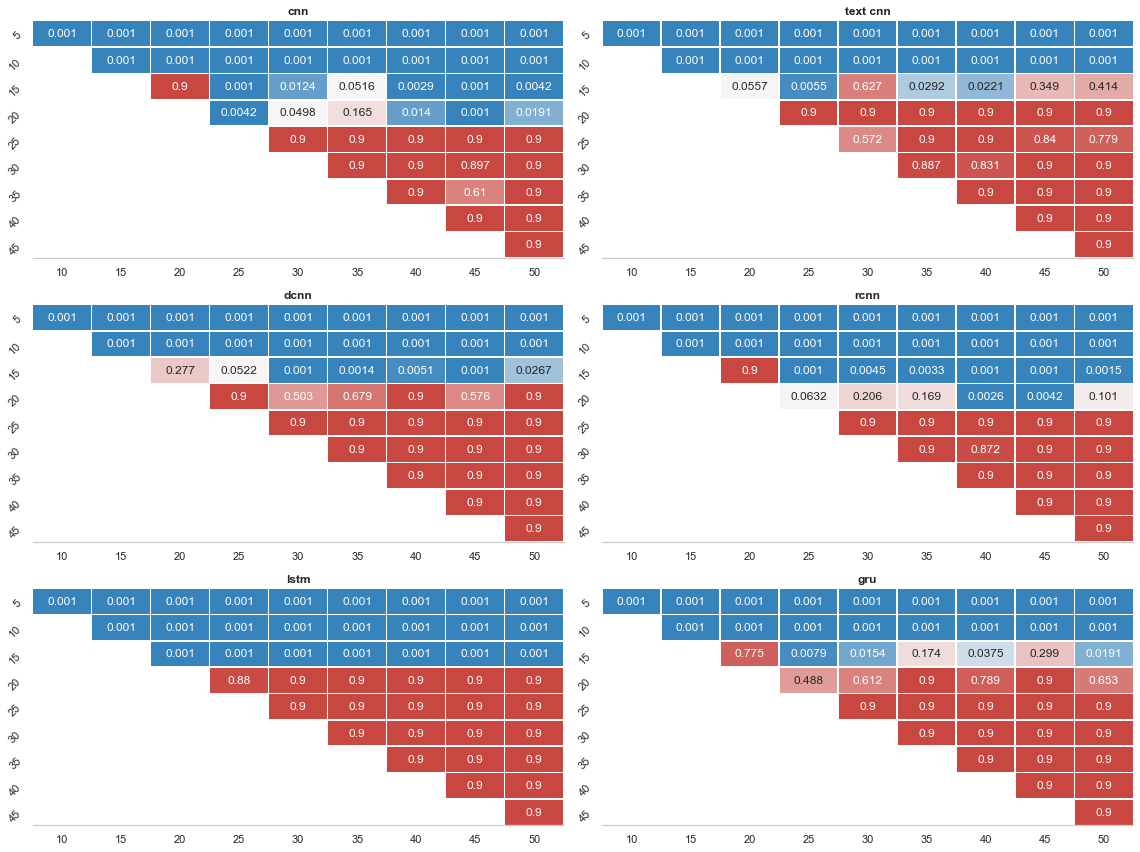

In [16]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(seq_data, exp_param, metric, show_result=False)

# Generate heatmaps
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.05, 1.0],
                        y_tick_rotation=45, height=4)
# g.savefig(os.path.join(task_name, exp_param, exp_param + '_anova.png'))

# Input Sequence Comparison

Compare a combination of vocabulary sizes (2.5k, 5k or 10k words) and sequence lengths (25, 50 or 128 tokens)
in small, medium and large groups.

In [17]:
# Name of the experiment parameters for comparison
exp_params = ['vocab_size', 'max_seq_length']
# Load experiment data
inseq_data = load_dataframe(os.path.join(task_name, 'input_seq', 'input_seq_data.csv'))
inseq_mean_data = load_dataframe(os.path.join(task_name, 'input_seq', 'input_seq_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(inseq_mean_data.loc[[inseq_mean_data['val_acc'].idxmax()], ['model_name'] + exp_params + ['val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(inseq_mean_data.loc[[inseq_mean_data['test_acc'].idxmax()], ['model_name'] + exp_params + ['test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']])
inseq_data_max = get_max(inseq_mean_data, exp_params)
inseq_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

Best validation accuracy in mean data:
  model_name  vocab_size  max_seq_length    val_acc  val_acc_std
3   text cnn        2500              25  75.408256      0.08534
Best test accuracy in mean data:
   model_name  vocab_size  max_seq_length   test_acc  test_acc_std  f1_weighted  f1_weighted_std
14       lstm       10000             128  72.901694      0.499982     0.698698          0.00682


,model_name,vocab_size,max_seq_length,val_acc,val_acc_std,vocab_size,max_seq_length,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,cnn,5000,50,74.86,0.24,10000,128,71.87,0.45,0.6899,0.0048
1,text cnn,2500,25,75.41,0.09,10000,128,72.63,0.63,0.6973,0.0086
2,dcnn,5000,50,74.68,0.24,10000,128,72.38,0.48,0.6940,0.0072
3,rcnn,10000,128,74.51,0.17,10000,128,71.90,0.52,0.6851,0.0066
4,lstm,10000,128,75.35,0.15,10000,128,72.90,0.50,0.6987,0.0068
5,gru,5000,50,74.37,0.17,10000,128,71.88,0.63,0.6837,0.0098


Test assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

Perform ANOVA comparing vocabulary size (2.5k, 5k or 10k words) and sequence lengths (25, 50 or 128 tokens) for each model.

NOTE:
- t-test comparing 'V=2.5k_S=25' and 'V=10k_S=128' only lstm shows significant difference.
- t-test comparing 'V=5k_S=50' and 'V=10k_S=128' no model shows significant difference.

In [18]:
# Add column to identify each combination
inseq_data = inseq_data.drop(inseq_data.columns.difference(['model_name', 'val_acc', 'vocab_size', 'max_seq_length']), axis=1)
conditions = [(inseq_data['vocab_size'] == 2500) & (inseq_data['max_seq_length'] == 25),
              (inseq_data['vocab_size'] == 5000) & (inseq_data['max_seq_length'] == 50),
              (inseq_data['vocab_size'] == 10000) & (inseq_data['max_seq_length'] == 128)]
choices = ['V=2.5k_S=25', 'V=5k_S=50', 'V=10k_S=128']
inseq_data['exp_params'] = np.select(conditions, choices)
inseq_data.drop(inseq_data[inseq_data.exp_params == '0'].index, inplace=True)

# Set the metric to test and new exp_param column
metric = 'val_acc'
exp_param = 'exp_params'

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(inseq_data, exp_param, metric)

# Run Levene test for equal variance
levene_test(inseq_data, exp_param, metric)

# Run ANOVA
one_way_anova_test(inseq_data, exp_param, metric)

The following exp_params are not normally distributed.
  model_name   exp_params    t-stat   p-value
9       rcnn  V=2.5k_S=25  0.826745  0.030571
The following models exp_params do not have equal variance.
  model_name  exp_params    t-stat   p-value
1   text cnn         NaN  3.960627  0.031024
The following models do not have significant p-values when comparing exp_params groups.
            sum_sq   df   mean_sq         F    PR(>F)    eta_sq  omega_sq   cohen_f     n       exp_n     power  exp_power
cnn       0.119722  2.0  0.059861  0.951665  0.398671  0.065852 -0.003233  0.063444  30.0  154.895525  0.197530        0.8
text cnn  0.068449  2.0  0.034224  0.838882  0.443149  0.058504 -0.010858  0.055925  30.0  175.307674  0.178610        0.8
dcnn      0.072505  2.0  0.036253  0.689531  0.510431  0.048594 -0.021135  0.045969  30.0  212.616171  0.153952        0.8
rcnn      0.345804  2.0  0.172902  2.167627  0.133956  0.138351  0.072220  0.144508  30.0   69.756496  0.404296        0.8


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq,cohen_f,n,exp_n,power,exp_power
cnn,0.119722,2.0,0.059861,0.951665,0.398671,0.065852,-0.003233,0.063444,30.0,154.895525,0.197530,0.8
text cnn,0.068449,2.0,0.034224,0.838882,0.443149,0.058504,-0.010858,0.055925,30.0,175.307674,0.178610,0.8
dcnn,0.072505,2.0,0.036253,0.689531,0.510431,0.048594,-0.021135,0.045969,30.0,212.616171,0.153952,0.8
rcnn,0.345804,2.0,0.172902,2.167627,0.133956,0.138351,0.072220,0.144508,30.0,69.756496,0.404296,0.8
lstm,0.223753,2.0,0.111876,2.808562,0.077964,0.172214,0.107598,0.187237,30.0,54.567207,0.505654,0.8
gru,0.279268,2.0,0.139634,2.189378,0.131471,0.139545,0.073467,0.145959,30.0,69.094973,0.407875,0.8


Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

,model_name,vocab_size,max_seq_length,val_acc,val_acc_std
0,cnn,2500,25,74.743838,0.204731
1,cnn,5000,50,74.858151,0.235315
2,cnn,10000,128,74.710674,0.302352
3,text cnn,2500,25,75.408256,0.085340
4,text cnn,5000,50,75.294693,0.294185
5,text cnn,10000,128,75.327086,0.169013
6,dcnn,5000,50,74.677440,0.243719
7,dcnn,2500,25,74.557039,0.175786
8,dcnn,10000,128,74.619072,0.259667
9,rcnn,2500,25,74.249954,0.375296


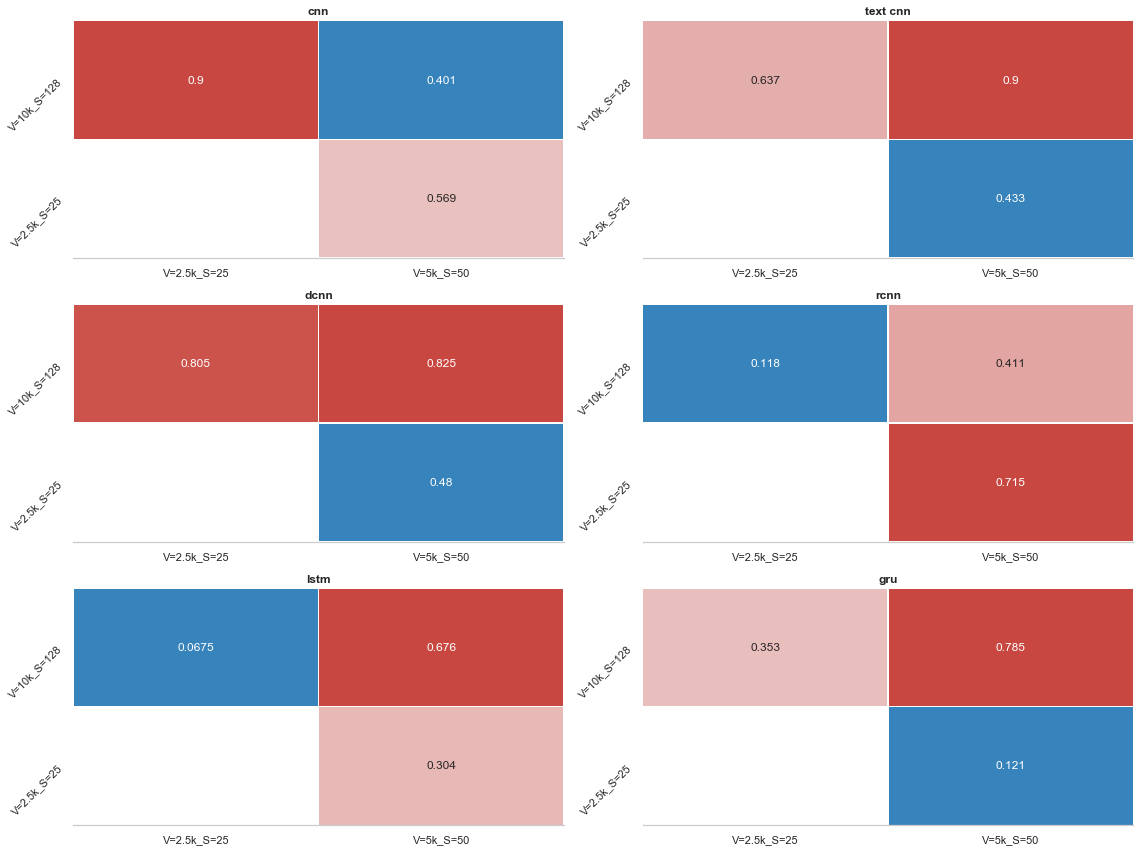

In [19]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(inseq_data, exp_param, metric, show_result=False)

# Generate heatmaps
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.05, 1.0],
                        y_tick_rotation=45, height=4)
# g.savefig(os.path.join(task_name, exp_param , exp_param + '_anova.png'))

# Show results for each group
inseq_mean_data = inseq_mean_data.drop(inseq_mean_data.columns.difference(['model_name', 'val_acc', 'val_acc_std', 'vocab_size', 'max_seq_length']), axis=1)
inseq_mean_data

# Word Vectors

Compare different dimensions of Word2Vec, GloVe, Fasttext, Numberbatch and Dependency for each model.
Dimension increments of 50 in the range [100, 300].

Get the embedding type and dimension corresponding to max validation and test accuracy per model.

In [20]:
# Name of the experiment parameter for comparison
exp_params = ['embedding_type', 'embedding_dim']

# Load language models experiment data
embed_data = load_dataframe(os.path.join(task_name, 'embedding_type', 'embedding_type_data.csv'))
embed_mean_data = load_dataframe(os.path.join(task_name,  'embedding_type', 'embedding_type_mean_data.csv'))

# Remove random embeddings because they are strictly worse
embed_data = embed_data.drop(embed_data[embed_data['embedding_type'] == 'random'].index)
embed_mean_data = embed_mean_data.drop(embed_mean_data[embed_mean_data['embedding_type'] == 'random'].index)

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(embed_mean_data.loc[[embed_mean_data['val_acc'].idxmax()], ['model_name'] + exp_params + ['val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(embed_mean_data.loc[[embed_mean_data['test_acc'].idxmax()], ['model_name'] + exp_params + ['test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']])
embed_data_max = get_max(embed_mean_data, exp_params)
embed_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

Best validation accuracy in mean data:
   model_name embedding_type  embedding_dim    val_acc  val_acc_std
48   text cnn    numberbatch            300  76.010386      0.12203
Best test accuracy in mean data:
   model_name embedding_type  embedding_dim   test_acc  test_acc_std  f1_weighted  f1_weighted_std
48   text cnn    numberbatch            300  73.663087      0.445725     0.713489         0.005253


,model_name,embedding_type,embedding_dim,val_acc,val_acc_std,embedding_type,embedding_dim,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,cnn,numberbatch,100,74.59,0.16,numberbatch,100,71.74,0.44,0.6888,0.0050
1,text cnn,numberbatch,300,76.01,0.12,numberbatch,300,73.66,0.45,0.7135,0.0053
2,dcnn,fasttext,200,75.66,0.15,glove,100,72.97,0.38,0.7031,0.0039
3,rcnn,fasttext,200,75.06,0.27,fasttext,250,72.70,0.60,0.6942,0.0080
4,lstm,glove,300,75.57,0.21,glove,300,73.11,0.50,0.7001,0.0064
5,gru,fasttext,100,74.87,0.28,fasttext,100,72.53,0.51,0.6932,0.0072


Heatmap plot of accuracy of each model per embedding type and dimension.

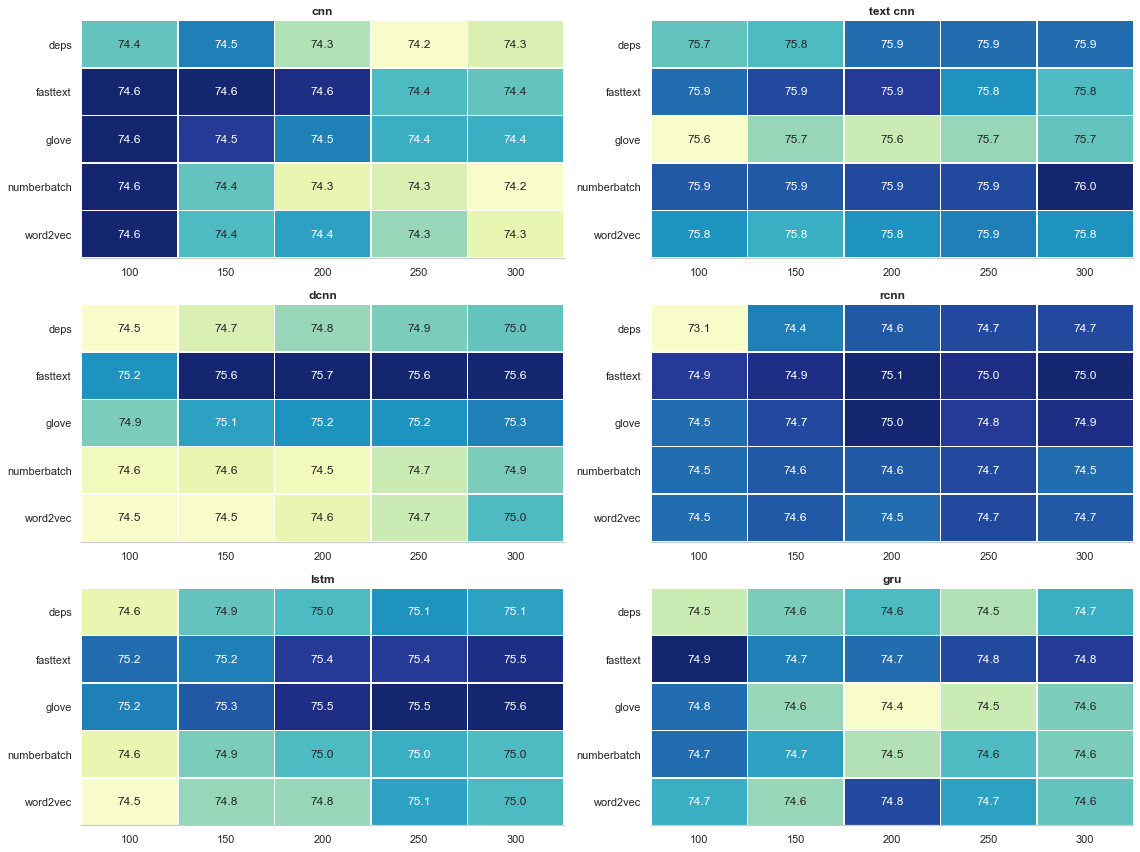

In [21]:
# Get test and validation accuracy for each model
embed_acc_data = embed_mean_data.drop(embed_mean_data.columns.difference(['model_name'] + exp_params + ['val_acc', 'test_acc']), axis=1)

g, fig = plot_facetgrid(embed_acc_data, x='embedding_type', y='embedding_dim', hue='val_acc', col='model_name',
                        kind='heatmap', title='', y_label='', x_label='', num_col=2, colour='YlGnBu', num_colour=20,
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, height=4)
g.savefig(os.path.join(task_name, 'embedding_type', 'embedding_type_accuracy.png'))

Test ANOVA assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

Perform Two-way ANOVA for each model, comparing different embedding type and dimension groups.

In [22]:
# Set the metric to test
metric = 'val_acc'

# Add embedding type and dimension column
embed_data['embedding_params'] = embed_data.apply(lambda row: row['embedding_type'] + "_" + str(row['embedding_dim']), axis=1)

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(embed_data, 'embedding_params', metric)

# Run Levene test for equal variance
levene_test(embed_data, 'embedding_params', metric)

# Run Two-way ANOVA
two_way_anova_test(embed_data, 'embedding_dim', 'embedding_type', metric, show_result=True)

The following embedding_params are not normally distributed.
    model_name embedding_params    t-stat       p-value
24         cnn        glove_150  0.798237  1.380062e-02
41    text cnn  numberbatch_250  0.843851  4.906363e-02
49    text cnn     word2vec_150  0.831870  3.524159e-02
58        dcnn  numberbatch_100  0.842730  4.757236e-02
63        dcnn     word2vec_250  0.814990  2.203972e-02
66        dcnn     word2vec_150  0.840200  4.436784e-02
72        dcnn     fasttext_200  0.843929  4.916905e-02
75        rcnn  numberbatch_300  0.650402  2.219227e-04
80        rcnn         deps_300  0.728703  1.964893e-03
81        rcnn         deps_100  0.443029  7.864205e-07
84        rcnn         deps_150  0.794356  1.237940e-02
86        rcnn        glove_100  0.823439  2.788741e-02
87        rcnn     fasttext_100  0.836128  3.964889e-02
98        rcnn        glove_300  0.796981  1.332367e-02
103       lstm     word2vec_150  0.778495  7.936632e-03
104       lstm        glove_250  0.836990  

,model_name,exp_params,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
0,cnn,C(embedding_dim),1.958277,4.0,0.489569,12.082762,6.501529e-09,0.153008,0.139902
1,cnn,C(embedding_type),1.182589,4.0,0.295647,7.296689,1.528966e-05,0.092400,0.079485
2,cnn,C(embedding_dim):C(embedding_type),0.541128,16.0,0.033821,0.834703,6.453150e-01,0.042280,-0.008346
3,text cnn,C(embedding_dim),0.158393,4.0,0.039598,0.750999,5.582713e-01,0.010856,-0.003586
4,text cnn,C(embedding_type),2.021419,4.0,0.505355,9.584295,3.572011e-07,0.138543,0.123641
5,text cnn,C(embedding_dim):C(embedding_type),0.547068,16.0,0.034192,0.648463,8.417759e-01,0.037495,-0.020253
6,dcnn,C(embedding_dim),5.848027,4.0,1.462007,31.920076,4.576958e-21,0.124477,0.120460
7,dcnn,C(embedding_type),29.247534,4.0,7.311884,159.640756,1.631945e-64,0.622542,0.618040
8,dcnn,C(embedding_dim):C(embedding_type),1.579799,16.0,0.098737,2.155740,7.232518e-03,0.033626,0.018010
9,rcnn,C(embedding_dim),8.408383,4.0,2.102096,3.287203,1.210895e-02,0.047514,0.032940


Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

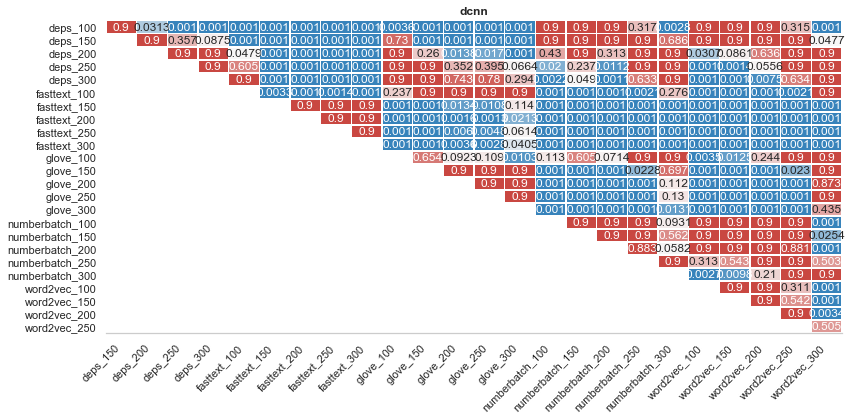

In [23]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(embed_data, 'embedding_params', metric, show_result=False)

# Just get the models where there is a significant difference
tukey_frame = tukey_frame[tukey_frame['model_name'] == 'dcnn']

# Generate tukey heatmap
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=1, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.05, 1.0],
                        y_tick_rotation=0, x_tick_rotation=45)
# g.savefig(os.path.join(task_name, 'embedding_type','embedding_type_anova.png'))

c:\python\virtual environments\venv-tf-1.15\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


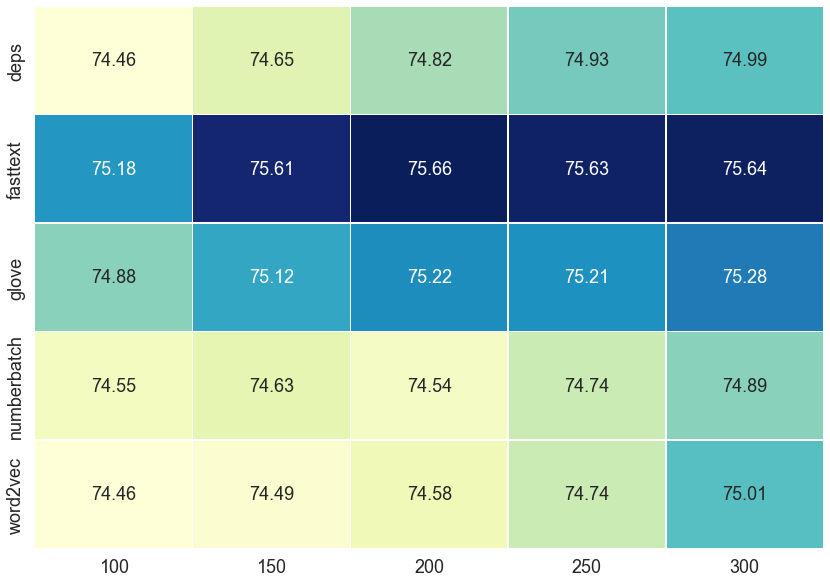

In [24]:
# Get only models that show significant effect
heatmap_data = embed_acc_data[embed_acc_data['model_name'] == 'dcnn']

# Generate accuracy heatmap
heatmap_data.drop(['model_name', 'test_acc'], axis=1, inplace=True)
heatmap_data = pd.pivot_table(heatmap_data, values='val_acc', index=['embedding_type'], columns='embedding_dim')
g = plot_heatmap(heatmap_data, title='', y_label='', x_label='', colour='YlGnBu', num_colour=100, square=False,
                     show_cbar=False, annotate=True, annot_font_size=18, num_format='.2f', y_tick_rotation=90)

g.savefig(os.path.join(task_name, 'embedding_type', 'embedding_type_dcnn_accuracy.png'))

# Input sequence and embeddings final results

Results for the 6 base models using the parameters (vocabulary size, sequence length and embeddings) from previous experiments.

In [25]:
# Name of the experiment parameter for comparison
exp_param = 'input_seq_final'

# Load language models experiment data
inseq_final_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
inseq_final_mean_data = load_dataframe(os.path.join(task_name,  exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(inseq_final_mean_data.loc[[inseq_final_mean_data['val_acc'].idxmax()], ['model_name', 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(inseq_final_mean_data.loc[[inseq_final_mean_data['test_acc'].idxmax()], ['model_name', 'test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']])
inseq_final_data_max = get_max(inseq_final_mean_data, [])
inseq_final_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

Best validation accuracy in mean data:
  model_name    val_acc  val_acc_std
1   text cnn  75.825126     0.210506
Best test accuracy in mean data:
  model_name   test_acc  test_acc_std  f1_weighted  f1_weighted_std
1   text cnn  73.362165       0.34404     0.709663         0.005089


,model_name,val_acc,val_acc_std,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,cnn,74.70,0.16,71.16,0.64,0.6818,0.0087
1,text cnn,75.83,0.21,73.36,0.34,0.7097,0.0051
2,dcnn,75.78,0.22,72.87,0.53,0.7057,0.0063
3,rcnn,74.97,0.15,72.44,0.41,0.6900,0.0059
4,lstm,75.76,0.16,73.06,0.37,0.6994,0.0041
5,gru,74.80,0.16,72.27,0.74,0.6901,0.0100


# Model variants results

Results and comparison for the bi-directional and multi-layer for recurrent models.
Results and comparison for the attentional variants of all 6 base models.

In [26]:
# Name of the experiment parameter for comparison
exp_param = 'model_variants'

# Load language models experiment data
variants_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
variants_mean_data = load_dataframe(os.path.join(task_name,  exp_param, exp_param + '_mean_data.csv'))

# Remove CRF because they are strictly worse
variants_data = variants_data[~variants_data['model_name'].str.contains('crf')]
variants_mean_data = variants_mean_data[~variants_mean_data['model_name'].str.contains('crf')]

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(variants_mean_data.loc[[variants_mean_data['val_acc'].idxmax()], ['model_name', 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(variants_mean_data.loc[[variants_mean_data['test_acc'].idxmax()], ['model_name', 'test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']])
variants_data_max = get_max(variants_mean_data, [])
variants_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

Best validation accuracy in mean data:
       model_name    val_acc  val_acc_std
13  text cnn attn  75.706358     0.156832
Best test accuracy in mean data:
       model_name   test_acc  test_acc_std  f1_weighted  f1_weighted_std
13  text cnn attn  73.445173       0.36633     0.711044         0.005255


,model_name,val_acc,val_acc_std,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,bi gru,74.35,0.26,72.34,0.28,0.6906,0.0048
1,bi lstm,74.94,0.20,72.26,0.78,0.6883,0.0123
2,cnn attn,74.91,0.30,72.14,0.70,0.6936,0.0086
3,dcnn attn,75.01,0.22,72.19,0.30,0.6981,0.0035
4,deep gru 2lyr,75.32,0.18,72.78,0.37,0.6968,0.0043
5,deep gru 3lyr,75.09,0.19,72.43,0.58,0.6917,0.0077
6,deep lstm 2lyr,75.40,0.14,73.28,0.54,0.7012,0.0064
7,deep lstm 3lyr,75.37,0.20,73.26,0.44,0.7018,0.0051
8,gru attn,74.99,0.20,72.51,0.30,0.6925,0.0043
9,lstm attn,75.67,0.11,72.85,0.59,0.6957,0.0075


Merge base and variant results

In [27]:
# Merge all of the supervised models results
final_data = pd.concat([inseq_final_data, variants_data], ignore_index=True)
final_data.drop('index', axis=1, inplace=True)

final_mean_data = pd.concat([inseq_final_mean_data, variants_mean_data], ignore_index=True)
final_mean_data.drop('index', axis=1, inplace=True)
final_mean_data = final_mean_data.drop(final_mean_data.columns.difference(['model_name', 'val_acc', 'val_acc_std',
                                                                           'test_acc', 'test_acc_std', 'f1_weighted',
                                                                           'f1_weighted_std']), axis=1)

metric = 'val_acc'

### Multi-layer

Test assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).
Run ANOVA between recurrent models and their multi layer (2 and 3 layers) variants.

In [28]:
# Get only the recurrent models and variants
deep_lstm_data = final_data[~final_data.model_name.str.contains('attn|cnn|rcnn|dcnn|gru|bi')]
deep_lstm_mean_data = final_mean_data[~final_mean_data.model_name.str.contains('attn|cnn|rcnn|dcnn|gru|bi')]

deep_gru_data = final_data[~final_data.model_name.str.contains('attn|cnn|rcnn|dcnn|lstm|bi')]
deep_gru_mean_data = final_mean_data[~final_mean_data.model_name.str.contains('attn|cnn|rcnn|dcnn|lstm|bi')]

print("LSTM Variants")

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(deep_lstm_data, 'model_name', metric)

# Run Levene test for equal variance
levene_test(deep_lstm_data, 'model_name', metric)

# Run ANOVA
bi_lstm_anova = one_way_anova_test(deep_lstm_data, 'model_name', metric)
print(bi_lstm_anova)

# Run Tukey-HSD post-hoc analysis
tukey_hsd(deep_lstm_data, 'model_name', metric)

print("GRU Variants")

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(deep_gru_data, 'model_name', metric)

# Run Levene test for equal variance
levene_test(deep_gru_data, 'model_name', metric)

# Run ANOVA
bi_gru_anova = one_way_anova_test(deep_gru_data, 'model_name', metric)
print(bi_gru_anova)

# Run Tukey-HSD post-hoc analysis
tukey_hsd(deep_gru_data, 'model_name', metric)

# Show multi-layer results
deep_recurrent_data = pd.concat([deep_lstm_mean_data, deep_gru_mean_data], ignore_index=True)
deep_recurrent_data = deep_recurrent_data[['model_name', 'val_acc', 'val_acc_std','test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']]
deep_recurrent_data.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

LSTM Variants
All models model_name are normally distributed.
All models have equal variance. P-value = 0.66524
The models have significant p-values when comparing groups. P-value = 2e-05
                 sum_sq    df   mean_sq          F    PR(>F)    eta_sq  omega_sq   cohen_f   n     exp_n    power  exp_power
C(model_name)  0.935216   2.0  0.467608  16.741982  0.000019  0.553601  0.512068  1.116132  30  12.18592  0.99917        0.8
Residual       0.754117  27.0  0.027930        NaN       NaN       NaN       NaN  1.116132  30  12.18592  0.99917        0.8
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1         group2     meandiff p-adj  lower  upper  reject
------------------------------------------------------------------
deep lstm 2lyr deep lstm 3lyr  -0.0302   0.9 -0.2155  0.155  False
deep lstm 2lyr           lstm   0.3585 0.001  0.1732 0.5438   True
deep lstm 3lyr           lstm   0.3887 0.001  0.2035  0.574   True
-----------------------------------

,model_name,val_acc,val_acc_std,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,lstm,75.76,0.16,73.06,0.37,0.6994,0.0041
1,deep lstm 2lyr,75.40,0.14,73.28,0.54,0.7012,0.0064
2,deep lstm 3lyr,75.37,0.20,73.26,0.44,0.7018,0.0051
3,gru,74.80,0.16,72.27,0.74,0.6901,0.0100
4,deep gru 2lyr,75.32,0.18,72.78,0.37,0.6968,0.0043
5,deep gru 3lyr,75.09,0.19,72.43,0.58,0.6917,0.0077


### Bi-directional

Run t-test comparing base recurrent models and their bi-directional variants.

In [29]:
# Get only base and bi-directional models
bi_lstm_data = final_data[~final_data.model_name.str.contains('attn|cnn|rcnn|dcnn|gru|deep')]
bi_lstm_mean_data = final_mean_data[~final_mean_data.model_name.str.contains('attn|cnn|rcnn|dcnn|gru|deep')]

bi_gru_data = final_data[~final_data.model_name.str.contains('attn|cnn|rcnn|dcnn|lstm|deep')]
bi_gru_mean_data = final_mean_data[~final_mean_data.model_name.str.contains('attn|cnn|rcnn|dcnn|lstm|deep')]

# Show bi-directional results
bi_directional_data = pd.concat([bi_lstm_mean_data, bi_gru_mean_data], ignore_index=True)
bi_directional_data = bi_directional_data[['model_name', 'val_acc', 'val_acc_std','test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']]
bi_directional_data.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

,model_name,val_acc,val_acc_std,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,lstm,75.76,0.16,73.06,0.37,0.6994,0.0041
1,bi lstm,74.94,0.20,72.26,0.78,0.6883,0.0123
2,gru,74.80,0.16,72.27,0.74,0.6901,0.0100
3,bi gru,74.35,0.26,72.34,0.28,0.6906,0.0048


In [30]:
print("LSTM Bi-directional Variants")

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(bi_lstm_data, 'model_name', metric)

# Run Levene test for equal variance
levene_test(bi_lstm_data, 'model_name', metric)

# Select the data to compare
data_a = bi_lstm_data.loc[(bi_lstm_data['model_name'] == 'lstm')][metric]
data_b = bi_lstm_data.loc[(bi_lstm_data['model_name'] == 'bi lstm')][metric]

# Perform power analysis
effect, exp_n, act_power = t_test_power_analysis(data_a, data_b, alpha=0.05, power=0.8)

# T-test
t, p = ttest_ind(data_a, data_b)
print("t-stat = " + str(t.round(5)) + " p-value = " + str(p.round(5)) + " cohen-d = " +  str(effect.round(5)) + " n = "
      + str(len(data_a)) + " exp_n = " +  str(int(exp_n)) +  " power = " + str(act_power.round(5)) +  " exp_power = " + str(0.8))

print("GRU Bi-directional Variants")

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(bi_gru_data, 'model_name', metric)

# Run Levene test for equal variance
levene_test(bi_gru_data, 'model_name', metric)

# Select the data to compare
data_a = bi_gru_data.loc[(bi_gru_data['model_name'] == 'gru')][metric]
data_b = bi_gru_data.loc[(bi_gru_data['model_name'] == 'bi gru')][metric]

# Perform power analysis
effect, exp_n, act_power = t_test_power_analysis(data_a, data_b, alpha=0.05, power=0.8)

# T-test
t, p = ttest_ind(data_a, data_b)
print("t-stat = " + str(t.round(5)) + " p-value = " + str(p.round(5)) + " cohen-d = " +  str(effect.round(5)) + " n = "
      + str(len(data_a)) + " exp_n = " +  str(int(exp_n)) +  " power = " + str(act_power.round(5)) +  " exp_power = " + str(0.8))

LSTM Bi-directional Variants
All models model_name are normally distributed.
All models have equal variance. P-value = 0.44535
t-stat = 9.98213 p-value = 0.0 cohen-d = 4.46414 n = 10 exp_n = 2 power = 1.0 exp_power = 0.8
GRU Bi-directional Variants
The following model_name are not normally distributed.
  model_name model_name    t-stat  p-value
0        gru        gru  0.832448  0.03581
All models have equal variance. P-value = 0.26167
t-stat = 4.64463 p-value = 0.0002 cohen-d = 2.07714 n = 10 exp_n = 4 power = 0.99235 exp_power = 0.8


### Attention

Run t-test comparing base models and their attentional variants.

In [31]:
# Get only base and attentional models
attn_data = final_data[~final_data.model_name.str.contains('bi|deep|crf')]
attn_mean_data = final_mean_data[~final_mean_data.model_name.str.contains('bi|deep|crf')]

# Show attentional results
attn_mean_data = attn_mean_data[['model_name', 'val_acc', 'val_acc_std','test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']]
attn_mean_data.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

,model_name,val_acc,val_acc_std,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,cnn,74.70,0.16,71.16,0.64,0.6818,0.0087
1,text cnn,75.83,0.21,73.36,0.34,0.7097,0.0051
2,dcnn,75.78,0.22,72.87,0.53,0.7057,0.0063
3,rcnn,74.97,0.15,72.44,0.41,0.6900,0.0059
4,lstm,75.76,0.16,73.06,0.37,0.6994,0.0041
5,gru,74.80,0.16,72.27,0.74,0.6901,0.0100
8,cnn attn,74.91,0.30,72.14,0.70,0.6936,0.0086
9,dcnn attn,75.01,0.22,72.19,0.30,0.6981,0.0035
14,gru attn,74.99,0.20,72.51,0.30,0.6925,0.0043
15,lstm attn,75.67,0.11,72.85,0.59,0.6957,0.0075


In [32]:
# Create results frame
attn_t_test_frame = pd.DataFrame(columns=['model_name', 't-stat', 'p-value'])

# Perform t-test for each model and its attn variant
for model in ['cnn', 'text cnn', 'dcnn', 'rcnn', 'lstm', 'gru']:

    current_attn_data = attn_data.loc[(attn_data['model_name'] == model) | (attn_data['model_name'] == model + ' attn')]

    # Run Shaprio-wilks test for normal distribution
    shapiro_wilk_test(current_attn_data, 'model_name', metric)

    # Run Levene test for equal variance
    levene_test(current_attn_data, 'model_name', metric)

    # Select the data to compare
    data_a = attn_data.loc[(attn_data['model_name'] == model)][metric]
    data_b = attn_data.loc[(attn_data['model_name'] == model + ' attn')][metric]

    # Perform power analysis
    effect, exp_n, act_power = t_test_power_analysis(data_a, data_b, alpha=0.05, power=0.8)

    # T-test
    t, p = ttest_ind(data_a, data_b)

    # Append to result frame
    attn_t_test_frame = attn_t_test_frame.append({'model_name': model, 't-stat': t, 'p-value': p, 'cohen-d': effect,
                                                  'n': len(data_a), 'exp_n': exp_n, 'power': act_power, 'exp_power': 0.8},
                                                 ignore_index=True)


if all(p_value <= 0.05 for p_value in attn_t_test_frame['p-value']):
    print("All models have significant p-values when comparing attention groups.")
else:
    print("The following models do not have significant p-values when comparing attention groups.")
    print(attn_t_test_frame.loc[attn_t_test_frame['p-value'] > 0.05])

attn_t_test_frame.round(5)

All models model_name are normally distributed.
All models have equal variance. P-value = 0.12609
All models model_name are normally distributed.
All models have equal variance. P-value = 0.55481
All models model_name are normally distributed.
All models have equal variance. P-value = 0.70823
All models model_name are normally distributed.
All models have equal variance. P-value = 0.53672
All models model_name are normally distributed.
All models have equal variance. P-value = 0.53494
The following model_name are not normally distributed.
  model_name model_name    t-stat  p-value
0        gru        gru  0.832448  0.03581
All models have equal variance. P-value = 0.44523
The following models do not have significant p-values when comparing attention groups.
  model_name    t-stat   p-value   cohen-d      exp_n  exp_power     n     power
0        cnn -1.959193  0.065765 -0.876178  21.452120        0.8  10.0  0.458054
1   text cnn  1.430742  0.169636  0.639847  39.326622        0.8  10.0

,model_name,t-stat,p-value,cohen-d,exp_n,exp_power,n,power
0,cnn,-1.95919,0.06577,-0.87618,21.45212,0.8,10.0,0.45805
1,text cnn,1.43074,0.16964,0.63985,39.32662,0.8,10.0,0.27304
2,dcnn,7.84686,0.00000,3.50922,2.66250,0.8,10.0,1.00000
3,rcnn,3.47050,0.00273,1.55205,7.60819,0.8,10.0,0.90662
4,lstm,1.32270,0.20250,0.59153,45.84316,0.8,10.0,0.24037
5,gru,-2.47092,0.02370,-1.10503,13.88469,0.8,10.0,0.64719


# Language Models

Using pre-trained language models to generate sequence representations.

In [33]:
# Name of the experiment parameter for comparison
exp_param = 'embedding_type'

# Load language models experiment data
lm_data = load_dataframe(os.path.join(task_name, 'language_models', 'language_models_data.csv'))
lm_mean_data = load_dataframe(os.path.join(task_name, 'language_models', 'language_models_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(lm_mean_data.loc[[lm_mean_data['val_acc'].idxmax()], ['model_name', 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(lm_mean_data.loc[[lm_mean_data['test_acc'].idxmax()], ['model_name', 'test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']])
lm_data_max = get_max(lm_mean_data, [exp_param])
lm_data_max.drop('embedding_type', axis=1, inplace=True)
lm_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

Best validation accuracy in mean data:
  model_name    val_acc  val_acc_std
1    roberta  78.166262     0.333614
Best test accuracy in mean data:
  model_name  test_acc  test_acc_std  f1_weighted  f1_weighted_std
1    roberta  76.21721      0.555866     0.736829         0.007001


,model_name,val_acc,val_acc_std,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,bert,76.87,0.24,76.07,0.42,0.7381,0.0053
1,roberta,78.17,0.33,76.22,0.56,0.7368,0.0070
2,gpt2,77.47,0.44,75.16,0.62,0.7267,0.0060
3,dialogpt,77.82,0.44,75.30,0.37,0.7280,0.0037
4,xlnet,78.15,0.46,75.88,0.45,0.7344,0.0069
5,convert,76.54,0.22,74.31,0.34,0.7189,0.0048
6,elmo,76.00,0.20,73.19,0.53,0.7095,0.0052
7,use,76.20,0.15,73.51,0.38,0.7124,0.0046
8,mlstm char lm,75.78,0.25,73.48,0.61,0.7117,0.0079
9,nnlm,73.44,0.07,70.12,0.26,0.6726,0.0030


Plot accuracy of each language model.

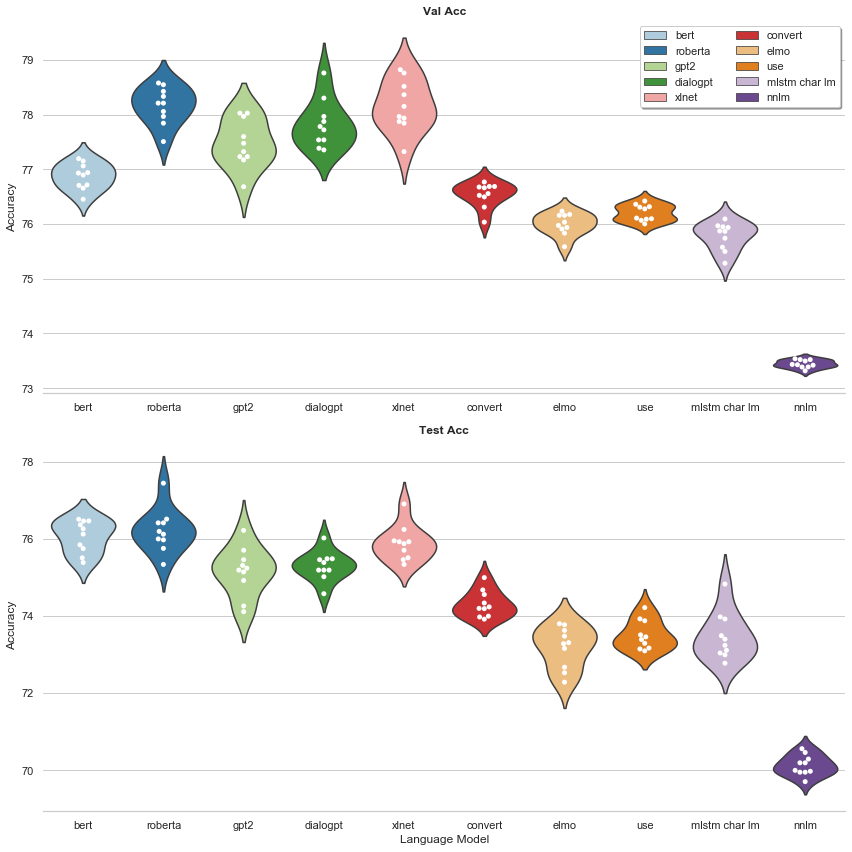

In [34]:
# Get test and validation accuracy for each model
lm_acc_data = lm_data.drop(lm_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
lm_acc_data = lm_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
lm_acc_data = lm_acc_data.melt(id_vars=['model_name', exp_param])

g, fig = plot_facetgrid(lm_acc_data, x="model_name", y="value", hue="model_name", col='variable', kind='swarm_violin',
                        num_legend_col=2, y_label='Accuracy', x_label='Language Model',
                        share_y=False, num_col=1, colour='Paired', dodge=False)
g.savefig(os.path.join(task_name, 'language_models', 'language_models' + '_accuracy.png'))

Test assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

Run t-tests to compare each language models with the best supervised model.

In [35]:
# Set the metric to test
metric = 'test_acc'

# Get the best supervised model
best_super = final_data.loc[(final_data['model_name'] == 'text cnn')]

# Get the top 5 language models
best_lm = lm_data[lm_data.model_name.str.contains('bert|roberta|gpt2|dialogpt|xlnet')]

# Create results frame
t_test_frame = pd.DataFrame(columns=['model_name', 't-stat', 'p-value'])

# Perform t-test for each language model and the supervised
for model_name in (lm_data['model_name'].unique()):

    # Select the current lm
    current_lm = lm_data.loc[(lm_data['model_name'] == model_name)]

    # Run Levene test for equal variance
    levene_test(pd.concat([current_lm, best_super]), 'model_name', metric)

    # Select the data to compare
    data_a = current_lm[metric]
    data_b = best_super[metric]

    # Perform power analysis
    effect, exp_n, act_power = t_test_power_analysis(data_a, data_b, alpha=0.05, power=0.8)

    # T-test
    t, p = ttest_ind(data_a, data_b)

    # Append to result frame
    t_test_frame = t_test_frame.append({'model_name': model_name, 't-stat': t, 'p-value': p, 'cohen-d': effect,
                                        'n': len(data_a), 'exp_n': exp_n, 'power': act_power, 'exp_power': 0.8},
                                       ignore_index=True)


if all(p_value <= 0.05 for p_value in t_test_frame['p-value']):
    print("All models have significant p-values when comparing with supervised.")
else:
    print("Some models do not have significant p-values when comparing with supervised.")
    print(t_test_frame.loc[t_test_frame['p-value'] > 0.05])
    
t_test_frame.round(5)


All models have equal variance. P-value = 0.53775
All models have equal variance. P-value = 0.48645
All models have equal variance. P-value = 0.33776
All models have equal variance. P-value = 0.94156
All models have equal variance. P-value = 0.8117
All models have equal variance. P-value = 0.83675
All models have equal variance. P-value = 0.33545
All models have equal variance. P-value = 0.89586
All models have equal variance. P-value = 0.29184
All models have equal variance. P-value = 0.49777
Some models do not have significant p-values when comparing with supervised.
      model_name    t-stat   p-value   cohen-d    exp_n  exp_power     n     power
6           elmo -0.864801  0.398527 -0.386751  105.917        0.8  10.0  0.129745
7            use  0.890028  0.385192  0.398033  100.053        0.8  10.0  0.134591
8  mlstm char lm  0.511018  0.615549  0.228534  301.526        0.8  10.0  0.077274


c:\python\virtual environments\venv-tf-1.15\lib\site-packages\statsmodels\stats\power.py:415: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
c:\python\virtual environments\venv-tf-1.15\lib\site-packages\statsmodels\stats\power.py:415: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
c:\python\virtual environments\venv-tf-1.15\lib\site-packages\statsmodels\stats\power.py:415: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
c:\python\virtual environments\venv-tf-1.15\lib\site-packages\statsmodels\stats\power.py:415: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)


,model_name,t-stat,p-value,cohen-d,exp_n,exp_power,n,power
0,bert,15.81571,0.00000,7.07300,[10.0],0.8,10.0,1.00000
1,roberta,13.81086,0.00000,6.17640,[10.0],0.8,10.0,1.00000
2,gpt2,7.95436,0.00000,3.55730,2.6333,0.8,10.0,1.00000
3,dialogpt,12.05155,0.00000,5.38962,2.0426,0.8,10.0,1.00000
4,xlnet,14.04848,0.00000,6.28267,[10.0],0.8,10.0,1.00000
5,convert,6.14097,0.00001,2.74633,3.37036,0.8,10.0,0.99994
6,elmo,-0.86480,0.39853,-0.38675,105.917,0.8,10.0,0.12974
7,use,0.89003,0.38519,0.39803,100.053,0.8,10.0,0.13459
8,mlstm char lm,0.51102,0.61555,0.22853,301.526,0.8,10.0,0.07727
9,nnlm,-23.69749,0.00000,-10.59784,[10.0],0.8,10.0,1.00000
